In [14]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
%matplotlib widget
import multiprocessing

In [2]:
x = np.arange(0,1000,2)
x_predict = np.arange(0,1000,0.2)

Prot = 25.
Pcyc = 300.
Hamp = 20.
Camp = 50.
y_mod = Hamp * np.sin(x/Prot*2*np.pi) + Camp * np.cos(x/Pcyc*2*np.pi)
y = np.random.normal(y_mod, 1 )
e = np.ones_like(y)

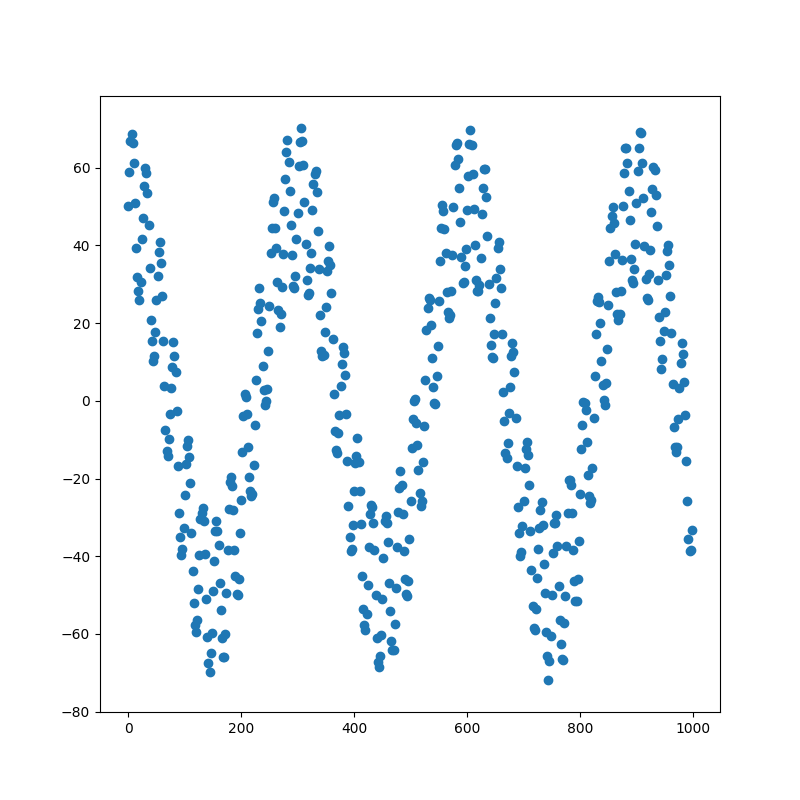

In [3]:
plt.figure(figsize=(8,8))
plt.errorbar(x, y, yerr=e, fmt='o')
plt.show()

In [4]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess

if sys.version_info[1] < 10:
    raise Warning("You should be using Python 3.10 - tinygp may not work")

def _build_tinygp_quasiperiodic_squaredexponential(params):
    kernel = jnp.power(params['Hamp'], 2.0) \
        * kernels.ExpSquared(scale=jnp.abs(params["Pdec"])) \
            * kernels.ExpSineSquared(
            scale=jnp.abs(params["Prot"]),
            gamma=jnp.abs(params["gamma"])) +  \
            jnp.power(params['Camp'], 2.0) \
            * kernels.ExpSquared(scale=jnp.abs(params["Pcyc"]))
    return GaussianProcess(
        kernel, params['x0'], diag=jnp.abs(params['diag']), mean=0.0
    )

@jax.jit
def _loss_tinygp_QPSE(params):
    gp = _build_tinygp_quasiperiodic_squaredexponential(params)
    return gp.log_probability(params['y'])


In [5]:


def tinygp_model(parameter_values):
    theta_dict =  dict(
        gamma=1. / (2.*parameter_values['Oamp'] ** 2),
        Hamp=parameter_values['Hamp'],
        Camp=parameter_values['Camp'],
        Pdec=parameter_values['Pdec'],
        Prot=parameter_values['Prot'],
        Pcyc=parameter_values['Pcyc'],
        diag=e**2,
        x0=x,
        y=y,
        x_predict= x_predict,
    )
    log_like = _loss_tinygp_QPSE(theta_dict)
    
    gp = _build_tinygp_quasiperiodic_squaredexponential(theta_dict)
    _, cond_gp = gp.condition(theta_dict['y'], theta_dict['x_predict'])
    mu = cond_gp.loc # or cond_gp.mean?
    std = np.sqrt(cond_gp.variance)
    return mu

def tinygp_qpmodel(parameter_values):
    theta_dict =  dict(
        gamma=1. / (2.*parameter_values['Oamp'] ** 2),
        Hamp=parameter_values['Hamp'],
        Camp=0.0000,
        Pdec=parameter_values['Pdec'],
        Prot=parameter_values['Prot'],
        Pcyc=10000000.,
        diag=e**2,
        x0=x,
        y=y,
        x_predict= x_predict,
    )
    log_like = _loss_tinygp_QPSE(theta_dict)
    
    gp = _build_tinygp_quasiperiodic_squaredexponential(theta_dict)
    _, cond_gp = gp.condition(theta_dict['y'], theta_dict['x_predict'])
    mu = cond_gp.loc # or cond_gp.mean?
    std = np.sqrt(cond_gp.variance)
    return mu

In [6]:
import george

def george_model(parameter_values):

    gp_pams = np.zeros(4)
    
    #parameter_values = {
    #    'Prot': 25.,
    #    'Pdec': 500000.,
    #    'Pcyc': 300.,
    #    'Oamp': 0.1,
    #    'Hamp': 20.,
    #    'Camp': 50.,
    #}
    
    gp_pams[0] = np.log(parameter_values['Hamp'])*2
    gp_pams[1] = np.log(parameter_values['Pdec'])*2
    gp_pams[2] = 1. / (2.*parameter_values['Oamp'] ** 2)
    gp_pams[3] = np.log(parameter_values['Prot'])
    
    kernel = np.exp(gp_pams[0]) * \
        george.kernels.ExpSquaredKernel(metric=np.exp(gp_pams[1])) * \
        george.kernels.ExpSine2Kernel(gamma=gp_pams[2], log_period=gp_pams[3])
    
    gp = george.GP(kernel)
    gp.compute(x, e)
    gp_y_predict = gp.sample_conditional(y, x_predict)
    return gp_y_predict

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


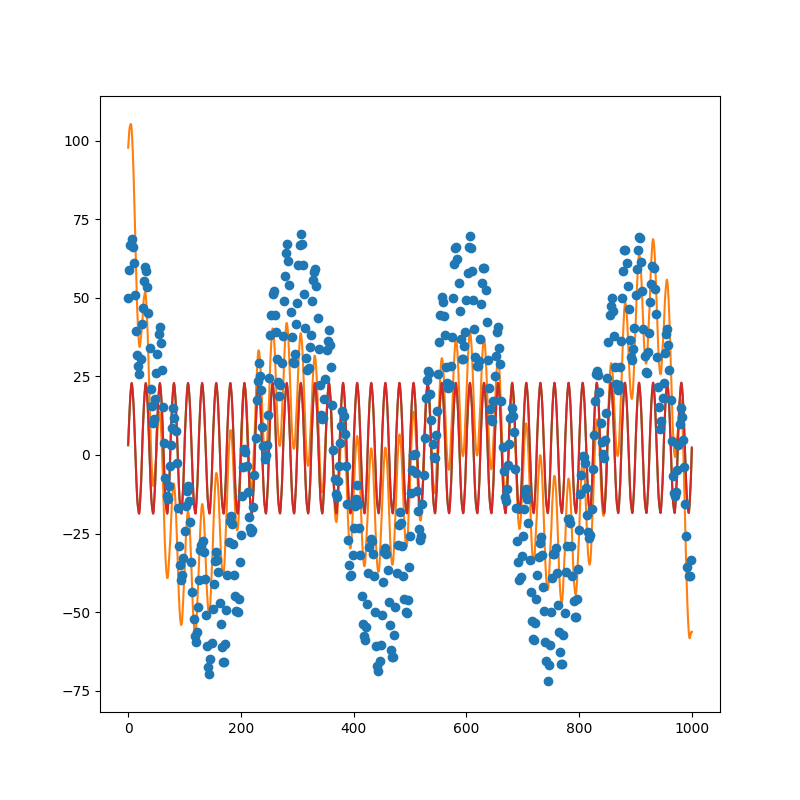

In [7]:
parameter_values = {
    'Prot': 25.,
    'Pdec': 500000.,
    'Pcyc': 300.,
    'Oamp': 0.35,
    'Hamp': 20.,
    'Camp': 50.,
}

tinygp_input_predict = tinygp_model(parameter_values)
tinyqp_input_predict = tinygp_qpmodel(parameter_values)
george_input_predict = george_model(parameter_values)

plt.figure(figsize=(8,8))
plt.errorbar(x, y, yerr=e, fmt='o')
plt.plot(x_predict, tinygp_input_predict)
plt.plot(x_predict, tinyqp_input_predict)
plt.plot(x_predict, george_input_predict)
plt.show()

In [8]:
def lnpost(theta):

    if not (all(theta > bounds[:,0]) and all(theta < bounds[:,1])):
        return -np.inf
    
    theta_dict =  dict(
    Prot=theta[0],
    Pdec=theta[1],
    Pcyc=theta[2],
    gamma=1. / (2.*theta[3] ** 2),
    Hamp=theta[4],
    Camp=theta[5],
    diag=e**2,
    x0=x,
    y=y,
    x_predict= x_predict,
    )
    return _loss_tinygp_QPSE(theta_dict)

In [9]:
from pyde.de import DiffEvol

#parameter_values = {
#    'Prot': 25.,
#    'Pdec': 500000.,
#    'Pcyc': 300.,
#    'Oamp': 0.1,
#    'Hamp': 20.,
#    'Camp': 50.,
#}

bounds_list = [
    [20.,30.],
    [2000.,3000.],
    [10.0,10000.],
    [0.0,2.0],
    [10.,100.],
    [10.,1000.]]

bounds = np.asarray(bounds_list)
npop = 4*len(bounds[:,0])
ngen = 10000
de = DiffEvol(lnpost, bounds, npop, maximize=True)
de.optimize(ngen)



(array([2.49998724e+01, 2.99932925e+03, 1.34312131e+02, 1.99985429e+00,
        3.05456180e+01, 1.29950315e+02]),
 819.936595325048)

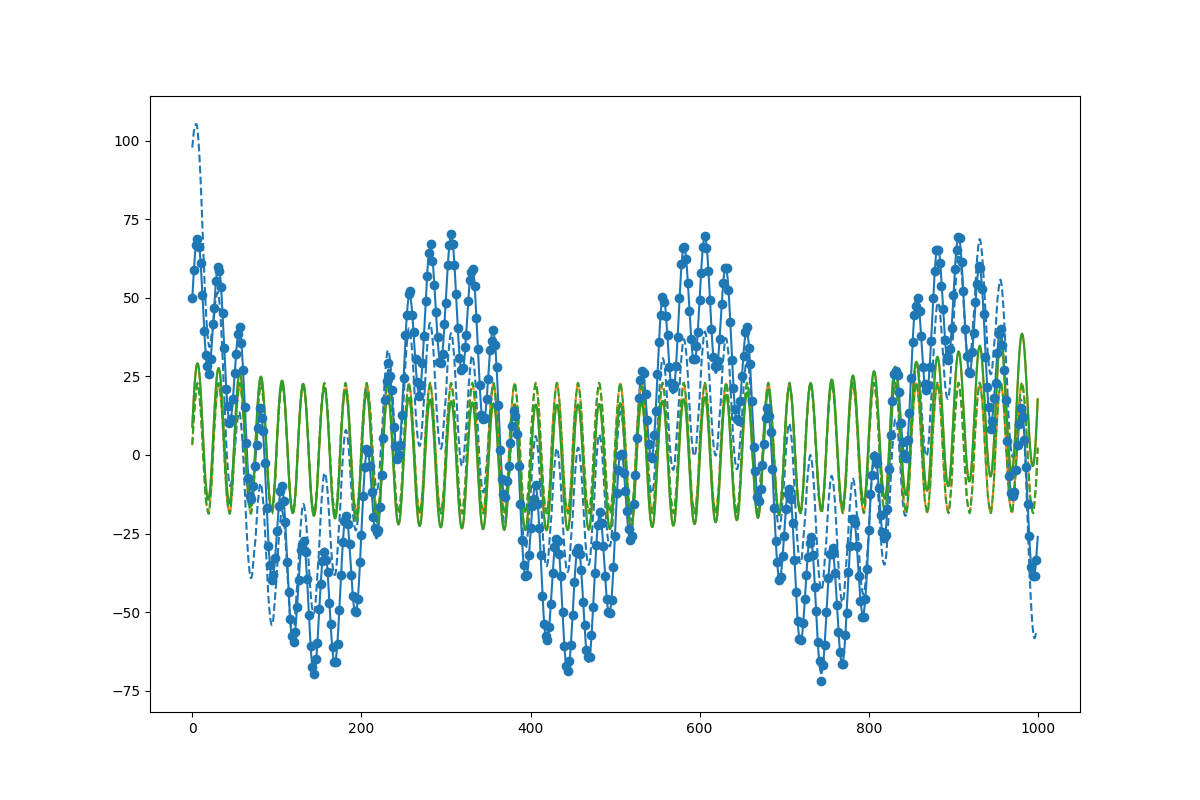

In [10]:
average_population = np.average(de.population, axis=0)
parameter_values = {
    'Prot': average_population[0],
    'Pdec': average_population[1],
    'Pcyc': average_population[2],
    'Oamp': average_population[3],
    'Hamp': average_population[4],
    'Camp': average_population[5],
}
tinygp_predict = tinygp_model(parameter_values)
tinyqp_predict = tinygp_qpmodel(parameter_values)
george_predict = george_model(parameter_values)

plt.figure(figsize=(12,8))
plt.errorbar(x, y, yerr=e, fmt='o')
plt.plot(x_predict, tinygp_predict, c='C0')
plt.plot(x_predict, tinygp_input_predict, c='C0', linestyle='--')

plt.plot(x_predict, tinyqp_predict, c='C1')
plt.plot(x_predict, tinyqp_input_predict, c='C1', linestyle='--')

plt.plot(x_predict, george_predict, c='C2')
plt.plot(x_predict, george_input_predict, c='C2', linestyle='--')
plt.show()

In [11]:
print(parameter_values)


{'Prot': 24.999713064652326, 'Pdec': 2998.983097273511, 'Pcyc': 134.4707166755779, 'Oamp': 1.9996346357929722, 'Hamp': 30.46988826542116, 'Camp': 130.80400559425755}


In [ ]:
import emcee
ndim = len(average_population)
sampler = emcee.EnsembleSampler(npop, ndim, lnpost)


with multiprocessing.Pool(12) as pool:
    sampler.pool = pool
    population, prob, state  = sampler.run_mcmc(de.population, 10000)